In [3]:
import ligo.skymap.plot
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

In [ ]:
import healpy as hp
import numpy as np
import collections
# load the milliquas catalog
milliquas = np.loadtxt('/data/milliquas.txt',usecols=(0,1))
nside = 128
ra = milliquas[:,0]
dec = milliquas[:,1]
AGNCountsArr = np.zeros(hp.nside2npix(nside))
AGN_ipix = hp.ang2pix(nside, ra, dec, lonlat=True)
ipixCounts = collections.Counter(AGN_ipix)
AGNCountsArr[list(dict(ipixCounts).keys())] = list(dict(ipixCounts).values())
AGN_milliquas = AGNCountsArr

/home/supernova/.conda/envs/GW/lib/python3.11/site-packages/healpy/visufunc.py:1503: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ax.graticule(dpar=dpar, dmer=dmer, coord=coord, local=local, **kwds)


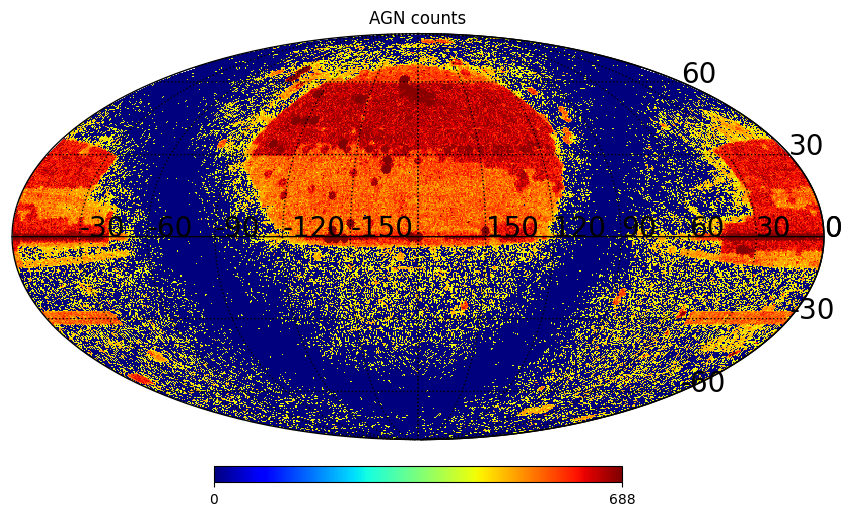

In [5]:
hp.mollview(AGNCountsArr,rot = (180,0,0), min = 0, title='AGN counts', cmap='jet',norm='hist')
def add_edges():
    hp.graticule(verbose=False)
    plt.grid(True)
    lons = np.arange(-150.0,180,30.0)
    lats = np.zeros(lons.shape)
    for lon, lat in zip(lons,lats):
        hp.projtext(lon,lat,"%.0f"%lon,lonlat=True, size=20)
    lats = np.arange(-60.0,90,30.0)
    lons = np.zeros(lons.shape)
    for lon, lat in zip(lons,lats):
        hp.projtext(lon,lat,"%.0f"%lat,lonlat=True, size=20)
add_edges()

In [5]:
wise = np.loadtxt('./data/r90cat.dat',delimiter='|',usecols=(1,2))
nside = 128
ra = wise[:,0]
dec = wise[:,1]
AGNCountsArr = np.zeros(hp.nside2npix(nside))
AGN_ipix = hp.ang2pix(nside, ra, dec, lonlat=True)
ipixCounts = collections.Counter(AGN_ipix)
AGNCountsArr[list(dict(ipixCounts).keys())] = list(dict(ipixCounts).values())
AGN_wise = AGNCountsArr

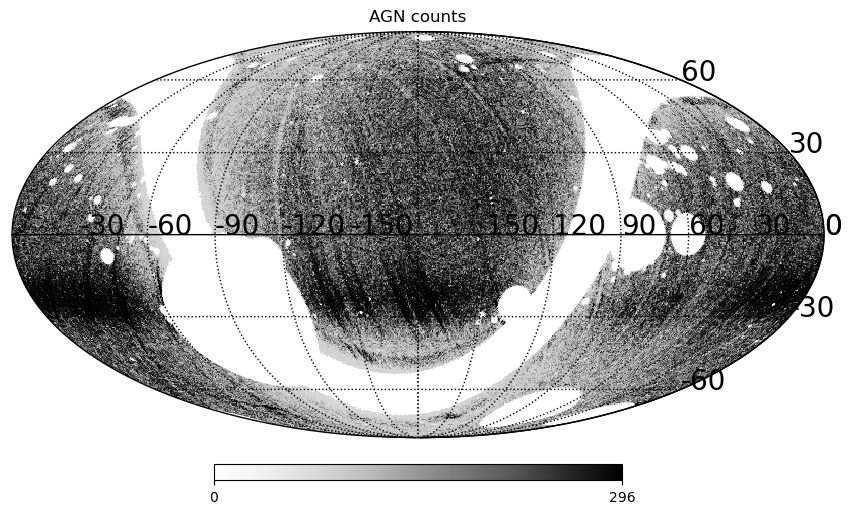

In [6]:
hp.mollview(AGNCountsArr,rot = (180,0,0), min = 0, title='AGN counts', cmap='Greys',norm='hist')
def add_edges():
    hp.graticule(verbose=False)
    plt.grid(True)
    lons = np.arange(-150.0,180,30.0)
    lats = np.zeros(lons.shape)
    for lon, lat in zip(lons,lats):
        hp.projtext(lon,lat,"%.0f"%lon,lonlat=True, size=20)
    lats = np.arange(-60.0,90,30.0)
    lons = np.zeros(lons.shape)
    for lon, lat in zip(lons,lats):
        hp.projtext(lon,lat,"%.0f"%lat,lonlat=True, size=20)
add_edges()

In [ ]:
from ligo.skymap.io import read_sky_map
from astropy.io import fits,ascii
import astropy_healpix as ah
from astropy.table import QTable
import healpy as hp
from ligo.skymap.postprocess import contour

def get_contour(skymap_path,contour_level=0.9):
    skymap = read_sky_map(skymap_path,distances=True, nest=True,moc=True)
    skymap.sort('PROBDENSITY',reverse=True)
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level))
    prob = pixel_area * skymap['PROBDENSITY']
    cumprob = np.cumsum(prob)
    i = cumprob.searchsorted(contour_level)
    skymap = skymap[:i]
    skymap.sort('UNIQ')
    threshold = min(skymap['PROBDENSITY'])
    print(threshold)
    skymap = read_sky_map(skymap_path)
    nsides = hp.npix2nside(len(skymap[0]))
    pixel_area = hp.nside2pixarea(nsides)
    path = contour(skymap[0]/pixel_area, levels=[threshold],degrees = True)
    print(type(path))
    if len(path[0][0]) < 10:
        return np.array(path[0][1])
    return np.array(path[0][0])

event_csv = ascii.read('/data/GW_events/100deg/O4ab_events_filtered.csv',format='csv')
graceids = event_csv['superevent_id']
print(graceids)
path = []
for i, graceid  in enumerate(graceids):
    print(graceid)
    path.append(get_contour(f'/data/GW_events/data/{graceid}_multiorder.fits',0.9))
    print(path[i])
print(path)

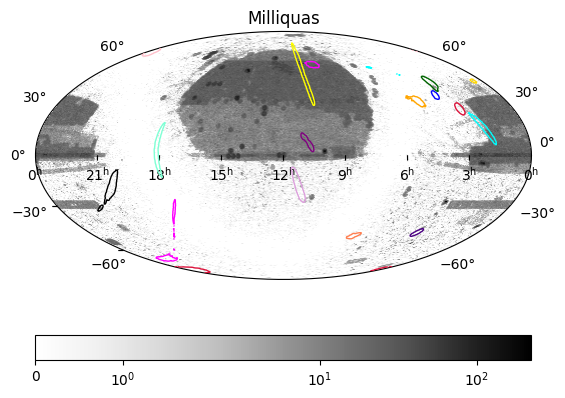

In [ ]:
from ligo.skymap import postprocess
from ligo.skymap.io import fits
from astropy.io import ascii

# plot GW skymap with milliquas AGNs
event_csv = ascii.read('/data/GW_events/100deg/O4ab_events_filtered.csv',format='csv')
graceids = event_csv['superevent_id']
ax = plt.axes(projection='astro mollweide')
img = ax.imshow_hpx(AGN_milliquas,cmap = 'Greys',norm='symlog')
plt.colorbar(img,orientation='horizontal')
colors = ['aquamarine','pink','black','blue','coral','crimson','cyan','darkgreen','gold','indigo','magenta','orange','plum','purple','yellow']
for i,graceid in enumerate(graceids):
    skymap, metadata = fits.read_sky_map(f'/data/GW_events/data/{graceid}_multiorder.fits', nest=None)
    cls = 100 * postprocess.find_greedy_credible_levels(skymap)
    ax.contour_hpx((cls, 'ICRS'),nested=metadata['nest'], linewidths=1, levels=[90],colors=f'{colors[i]}')
    # ax.text(event_csv['ra'][i],event_csv['dec'][i],f'{graceid}',color=f'{colors[i]}',fontsize=8)


plt.title('Milliquas')
plt.savefig('O4ab_skymap.png',dpi=600)